<a href="https://colab.research.google.com/github/TAYAyuki/adversarial_example/blob/master/KerasPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Reshape, \
BatchNormalization, UpSampling2D, Activation, Input, LeakyReLU, Dropout, \
Flatten, MaxPooling2D, ReLU
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend

# Adversarial 
## Gradient based
### Fast Gradient Sign Method (FGSM)
### $x^{2}$ = x + $\varepsilon$sign($\nabla_{x}$L(x,y))

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(x_train.shape)
x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)
x_train = x_train/255.
x_test = x_test/255.
print(x_train.shape)


# CNN version
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
a = Input(shape=(28,28,1))
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(a)
x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)

# full connection version
# a= Input(shape=(28*28,))
# x = Dense(units=512, activation='relu', input_shape=(28*28,))(a)
# x = Dense(units=128, activation='relu')(x)
# x = Dense(units=64, activation='relu')(x)
# x = Dense(units=10, activation='softmax')(x)

model = Model(inputs=a, outputs=x)

model.summary()

model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

# sneaky_generate(target label, target digit)
# def adversarial(model, n, steps, eta):
#   """
#   model: MNIST model
#   n:     integer. goal label (just an int, the function transfroms it into a one-hot vector)
#   steps: integer. number of steps for gradient descent
#   eata:  integer. step size for gradient descent
#   """
#   # Set the goal output
#   goal = tf.keras.utils.to_categorical(n, 10)
  
#   # Create a random image to initialize gradient descent with
#   x = np.random.normal(.5, .3, (1,28,28,1))
  
#   # Gradient descent on the input
#   for i in range(steps):
#     # Calculate the derivative
#     d = input_derivative(model, x, goal)
#     # The Gradient update on x
#     x -= eta*d[0]
#     print("step:{} done...".format(i+1))
    
#   return x


# def generate(n):
#   """
#   n: integer
#       goal label ( not hot vector)
#   """
#   a = adversarial(model, n, 100, 1)
#   x = np.round(model.predict(a), 2)
  
#   plt.imshow(a.reshape(28,28), cmap='gray')

(60000, 28, 28)
(60000, 784)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                1003530   
Total params: 1,096,202
Trainable params:

In [0]:
def input_derivative(model, x, goal):
  """ Calculate derivatives wrt the intputs """
  y_true = Input(shape=(10,))
  ce = categorical_crossentropy(y_true, model.output)
  grad_ce = backend.gradients(ce, model.inputs)
  # Create a function to be able to run this computation graph
  func = backend.function(model.inputs+[y_true], grad_ce)
  output = func([x, goal])
  return output
  
  
def sneaky_adversarial(model, n, x_target, steps, eta, lam=0.05):
  """
  model:    model object
  n:        integer
          our toal label
  x_target: numpy vector
          our goal image for the adversarial example
  steps:    integer
          number of steps for gradient descent
  lam:      float
          lambda, our regularization parameter. Default is 0.5
  """
  
  # Set the goal output
  goal = tf.keras.utils.to_categorical(n, 10)
  
  # Create a random noise
  x = np.random.normal(0.5, 0.3, (1,784))
  x = x.reshape(1,28,28,1)  # inputs for CNN
#   x = x.reshape(1,28*28)
  
  # Gradient descent on the input
  for i in range(steps):
    # Calculate the derivative
    d = input_derivative(model, x, goal)
    
    # difference between x and x_target
#     diff = x - x_target
#     noise = d[0]
#     print("diff: {}\nnoise: {}".format(np.mean(diff), np.mean(noise)))
#     print("---------------------------------")
    
    # The grads update on x, with an added penalty to the cost function
    x -= eta * (d[0] + lam * (x - x_target))
    
    # print predction in current step
#     currentPred = np.round(model.predict(x), 2)
#     print('Network Prediction: ' + str(currentPred) + '\n')
    
    if (i+1) % 10 == 0:
      plt.imshow(x.reshape(28,28), cmap='gray')
      plt.show()
      print('steps:{} done...'.format(i+1))
    
  return x


def sneaky_generate(n, m, steps):
  """
  n:    int 0-9, the target number to match
  m:    index of example image to use (from the test set)
  """
  
  # Find random instance of m in test set
  idx = np.random.randint(0,10000)
  while np.where(y_test[idx] == 1)[0][0] != m:
    idx += 1
    
  
  x_target = x_test[idx].reshape((28,28,1))
  # Hardcode the parameters for the wrapper function
  a = sneaky_adversarial(model, n, x_target, steps, 1)
  x = np.round(model.predict(a), 2)
  
  print('\nWhat we want our adversarial example to look like: ')
  plt.imshow(x_test[idx].reshape((28,28)), cmap='gray')
  plt.show()

  print('\n')

  print('Adversarial Example: ')

  plt.imshow(a.reshape(28,28), cmap='gray')
  plt.show()

  print('Network Prediction: ' + str(np.argmax(x)) + '\n')

  print('Network Output: \n' + str(x) + '\n')

  return a

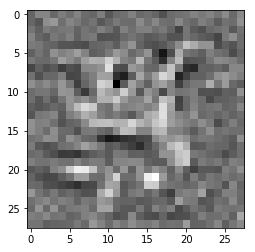

steps:10 done...


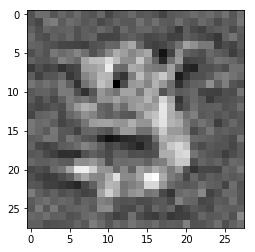

steps:20 done...


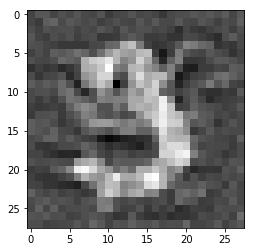

steps:30 done...


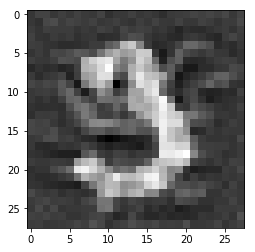

steps:40 done...


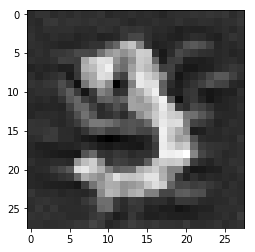

steps:50 done...


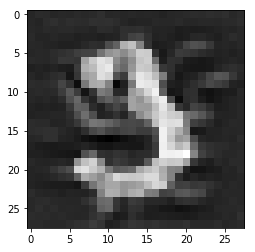

steps:60 done...


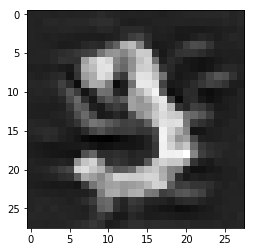

steps:70 done...


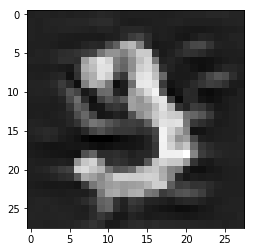

steps:80 done...


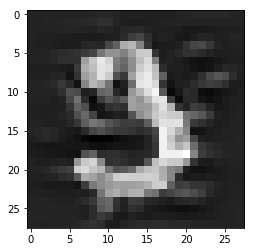

steps:90 done...


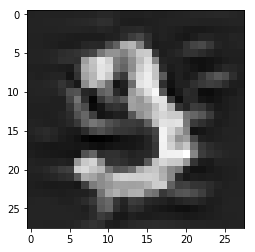

steps:100 done...

What we want our adversarial example to look like: 


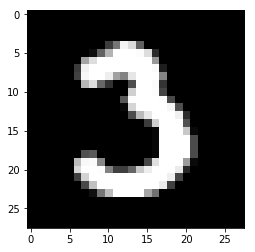



Adversarial Example: 


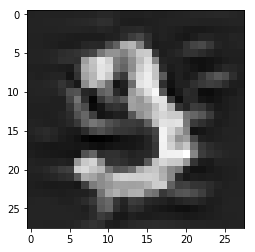

Network Prediction: 4

Network Output: 
[[0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.  ]]



In [0]:
    adv_ex = sneaky_generate(4, 3, 100)

### Projected Gradient Descent
### (Iterative FGSM)
$x_{0}^{*}$ = x,
$x_{t+1}^{*}$ = clip(x + $\alpha$sign($\nabla_{x}$L($x_{t}^{*}$,y)))

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(x_train.shape)
x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)
x_train = x_train/255.
x_test = x_test/255.
print(x_train.shape)

a= Input(shape=(28*28,))
x = Dense(units=512, activation='relu', input_shape=(28*28,))(a)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=10, activation='softmax')(x)
model = Model(inputs=a, outputs=x)
model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

(60000, 28, 28)
(60000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.2294 - acc: 0.9303 - val_loss: 0.1077 - val_acc: 0.9674
Epoch 2/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.0849 - acc: 0.9733 - val_loss: 0.1165 - val_acc: 0.9639
Epoch 3/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0542 - acc: 0.9829 - val_loss: 0.0680 - val_acc: 0.9797
Epoch 4/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0376 - acc: 0.9882 - val_loss: 0.0684 - val_acc: 0.9809
Epoch 5/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0265 - acc: 0.9916 - val_loss: 0.0634 - val_acc: 0.9836


# GAN 
## mnist

In [0]:
class MnistGAN:
  
  def __init__(self):
    self.z_dim = 100
    self.shape = (28,28,1)
    optimizer = Adam(lr=1e-4, beta_1=0.5)
    
    # build discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', \
                               optimizer=optimizer, \
                               metrics=['acc'])
    
    # buid generator 
    self.generator = self.build_generator()   
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    
    # fix the parameters of discriminator
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    
    # for training generator
    self.combined = Model(z, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
  
  
  def build_generator(self):
    noise_shape = (self.z_dim,)    
    model = Sequential()
    
    #-----------------------#
    model.add(Dense(7*7*128, activation='relu', input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())                   # (14,14,128)
    #-----------------------#
    model.add(Conv2D(8, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())                   # (28,28,128)
    #-----------------------#
    model.add(Conv2D(4, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.8)) # (28,28,64) 
    #-----------------------#
    model.add(Conv2D(1, kernel_size=3, padding='same'))
    model.add(Activation('tanh'))
    
    model.summary()
    
    noise = Input(shape=noise_shape)
    
    img = model(noise)
    
    return Model(inputs=noise, outputs=img)
  
  def build_discriminator(self):
    img_shape = self.shape
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    #--------------------------------
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
#     model.add(BatchNormalization(momentum=0.8))
#     #--------------------------------
#     model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.25))
#     model.add(BatchNormalization(momentum=0.8))
#     #--------------------------------
#     model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.25))
   
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    img = Input(shape=img_shape)
    validity = model(img)
    
    return Model(inputs=img, outputs=validity)
  
  
  def build_combined(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    
    return model

  
  def train(self, iterations, batch_size=128, save_interval=50, model_interval=1000, check_noise=None, r=5, c=5): 
   #iterations:3000 
    x_train, y_train, x_test, y_test = self.load_imgs()
    #x_train:(60000,28,28,1)  y_train:(60000,10)
    print(x_train.shape)
    print(y_train.shape)
    half_batch = int(batch_size / 2)
    
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    
    for iteration in range(iterations):
      """
      Training Discriminator
      """
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      
      imgs = x_train[idx]
      
      noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)
      
      
      d_loss_real = self.discriminator.train_on_batch(imgs, \
                                                      np.ones((half_batch, 1)))
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, \
                                                      np.zeros((half_batch, 1)))
    
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      
      """
      Training Generator
      """
      noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
      
      g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
      
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))

      for i in range(9):
        plotImg = gen_imgs[i].reshape(28,28)
        plt.subplot(3,3,i+1)
        plt.imshow(plotImg, cmap='gray')
      plt.show()
      
    
  def load_imgs(self):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    y_train = tf.keras.utils.to_categorical(y_train, 10) #train correct answer data -> one hot vector
    print(y_train.shape)
    y_test = tf.keras.utils.to_categorical(y_test, 10) #test correct answer data -> one hot vector
    print(y_test.shape)
    print(x_train.shape)
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1)) 
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
    return x_train, y_train, x_test, y_test

In [3]:
mnistGAN = MnistGAN()
mnistGAN.train(iterations=3000)

W0620 09:08:23.300964 140238245767040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0620 09:08:23.527497 140238245767040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

KeyboardInterrupt: ignored

# CapsuleNet on MNIST

$S_{j}$ = $\sum_{i}C_{ij}\widehat{u}_{j|i},{u}_{i|j} = W_{ij}u_{i}$  \\
$V_{j} = squash(S_{j}) =\frac{\Vert S_{j}\Vert}{0.5+\Vert S_{j}\Vert^{2}}S_{j}$

In [0]:
def squash(x, axis=-1):
  s_squared_norm = backend.sum(backend.square(x), axis=asix, keepdims=True) + backend.epsilon()
  scale = backend.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
  return scale * x

$c_{ij} = \frac{e^{b_{ij}}}{\sum}_{ke^{b_{ik}}}$

In [0]:
def softmax(x, axis=-1):
  ex = backend.exp(x - backend.max(x, axis=axis, keepdims=True))
  sum_ex = backend.sum(ex, axis=axis, keepdims=True)
  return ex / sum_ex

### call function

In [0]:
def call(self, inputs):
  batch_size = backend.shape(inputs)[0]          # enumerial of batch
  input_num_capsule = backend.shape(inputs)[1]   # the number of capsule
  
  hat_inputs = Conv1D(inputs, kernel=self.kernel)
  hat_inputs = Reshape(hat_inputs, shape=(batch_size, input_num_capsule))

### CapsNet-keras-MNIST
#### CapsuleLayer

In [0]:
"""
Some key layers used for constructing a Capsule Network.
"""
class Length(tf.keras.layers.Layer):
  """
  Compute length of vectors。 This is used to compute a Tensor that has the 
  same shape with y_ture in margin_loss. Using this layer as model's output
  can directly predict labels by using 'y_pred = np.argmax(model.predict(x), 1)'
  inputs: shape = [None, num_vectors, dim_vector]
  output: shape = [None, num_vectors]
  """
  def call(self, inputs, **kwargs):
    return backend.sqrt(backend.sum(bakcend.square(inputs), -1))
  
  def compute_output_shape(self, input_shape):
    return input_shape[:-1]
  
  def get_config(self):
    config = super(Length, self).get_config()
    return config
  

class Mask(tf.keras.layers.Layer):
  """
  Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule
  with max length or by an additional input mask. Except the max-lenght capsule
  (or specified capsule), all vectors are masked to zeros. Then flatten the masked
  Tensor.
  For example:
    '''
    x = keras.layers.Input(shape=[8, 3, 2]) #batch_size=8, each sample contains 3 capsules with dim_vector=2
    y = keras.layers.Input(shape=[8, 3]) # True labels. 8 samples, 3 calasses, one-hot coding.
    out = Mask()([x,y]) # out2.shape=[8,6]. Masked with true labels y. Of course u can also be manipulated.
    '''
  """
  def call(self, inputs, **kwargs):
    if type(inputs) is list: # true label is provided with shape = [None, n_classes], i.e. one-hot code.
      assert len(inputs) == 2
      inputs, mask = inputs
    else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
      # compute lengths of capsules
      x = backend.sqrt(backend.sum(backend.square(inputs), -1))
      # generate the mask which is a one-hot code.
      # mask.shape = [None, n_classes] = [None, num_capsule]
      mask = backend.one_hot(indices=backend.argmax(x, 1), num_classes=x.get_shape().as_list()[1])
      
  # inputs.shape=[None, num_capsule, dim_capsule]
  # mask.shape=[None, num_capsule]
    masked = backend.batch_flatten(inputs * backend.expand_dims(mask, -1))
    return masked
      
  
  def compute_output_shape(self, input_shape):
    if type(input_shape[0]) is tuple: # true label provided
      return tuple([None, input_shape[0][1] * input_shape[0][2]])
    else: # no true label provided
      return tuple([None, input_shape[1] * input_shape[2]])
    
    
  def get_config(self):
    config = super().get_config() # get config from tensorflow.keras.layers.Layer
    return config
      
      
def squash(vectors, axis=-1):
  """
  The non-linear activation used in Capsule. It drives the length of a large vector
  to near 1 and small vector to 0
  :param vectors: some vectors to be squashed, N-dim tensor
  :param axis: the axis to squash
  ]return: a Tensor with same shape as input vectors
  """
  s_squared_norm = backend.sum(backend.square(vectors), axis, keepdims=True)
  scale = s_squared_norm / (1 + s_squared_norm) / backend.sqrt(s_sauqred_norm + backend.epsilon())
  return scale * vectors
  
      
class CapsuleLayer(tf.keras.layers.Layer):
  """
  The capsule layer. It is similar to Dense layer. Dense layer has 'in_num' inputs, 
  each is a scalar, the output of the neuron from the former layer, and it has 'out_num'
  output neurons. CapsuleLayer just expand the output of the neuron from scalar to vector.
  So its input  shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
  [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
  """
  def __init__(self, num_capsule, dim_capsule, routings=3,\
               kernel_inintializer='glorot_uniform'):
    super().__init__(**kwargs)
    self.num_capsule = num_capsule
    self.dim_capsule = dim_capsule
    self.routings = routings
    self.kernel_initializer = initializer.get(kernel_initializer)
    
  def build(self, input_shape):
    assert len(input_shape) >= 3, ' The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule] '
    self.input_num_capsule = input_shape[1]
    self.input_dim_capsule = input_shape[2]
    
    # Transform matrix
    self.W = self.add_weight(shap=[self.num_capsule, self.input_num_capsule,\
                                   self.dim_capsule, self.input_dim_capsule],
                             initializer=self.kernel_initializer,
                             name='W')
    
    self.build = True
    
    
  def call(self, intpus, training=None):
    # inputs.shape=[None, input_num_capsule, input_dim_capsule]
    # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
    inputs_expand = backend.dims(inputs, 1)
    
    # Replicate num_capsule dimension to prepare being multiplied by W
    # inputs_tiled.shape=[None, num_capsule, input_num_capsule, dim_capsule]
    inputs_hat = backend.map_fn(lambda x: backend.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)
    
    # Begin: Routing algorithm -------------------------------------------------#
    # The prior for coupling coefficient, initialized as zeros.
    # b.shape = [None, self.num.capsule, self.input_num_capsule].
    b = tf.zeros(shape=[K.shape(input_hat)[0], self.num_capsule, self.input_num_capusle])
    
    assert self.routings > 0, ' The routings should be > 0. '
    for i in range(self.routings):
      # c.shape=[None, self.num_capsule, self.input_num_capsule].
      c = tf.nn.softmax(b, dim=1)
      
      # c.shape = [batch_size, num_capsule, input_num_capsule]
      # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
      # The first two dimensions as 'batch' dimension,
      # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule]
      # outputs.shape=[None, num_capsule, dim_capsule]
      outputs = squash(backend.batch_dot(c, inputs_hat, [2, 2])) # [None, 10, 16]
      
      if i < self.routings -1:
        # outputs.shape = [None, num_capsule, dim_capsule]
        # input_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        # The first two dimensions as 'batch' dimension,
        # then matmal: [dim_capusle] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
        # b.shape=[batch_size, num_capsule, input_num_capsule]
        b += backend.batch_dot(outputs, inputs_hat, [2, 3])
        
    # End: Routing algorithm ---------------------------------------------------#
    
    return outputs
  
  
  def comput_output_shape(self, input_shape):
    return tuple([None, self.num_capsule, self.dim_capsule])
  
  
  def get_config(self):
    config = {
        'num_capsule': self.num_capsule,
        'dim_capsule': self.dim_capsule,
        'routings': self.routings
    }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))
    

def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
  """
  Apply Conv2D 'n_channels' times and concatenate all capsules
  :param inputs: 4D tensor, shape=[None, width, height, channels]
  :param dim_capsule: the dim of the output vector of capsule
  :param n_channels: the number of types of capsules
  :return: output tensor shape=[None, num_capsule, dim_capsule]
  """
  output = Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, \
                  strides=strides, padding=padding, name='primarycap_conv2d')(inputs)
  outputs = Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
  return tf.keras.layers.Lambda(squash, name='primaricap_squash')(outputs)


"""
# The following it another way to implement primary capsule layer, This is much slower.
# Apply Conv2D 'n_channels' times and concatenate all capsules

def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
  outputs = []
  for _ in range(n_channels):
    ooutput = Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, \
                  strides=strides, padding=padding, name='primarycap_conv2d')(inputs)
    outputs.append(Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    return tf.keras.layers.Lambda(squash)(outputs)
""" 

"\n# The following it another way to implement primary capsule layer, This is much slower.\n# Apply Conv2D 'n_channels' times and concatenate all capsules\n\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n  outputs = []\n  for _ in range(n_channels):\n    ooutput = Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size,                   strides=strides, padding=padding, name='primarycap_conv2d')(inputs)\n    outputs.append(Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    return tf.keras.layers.Lambda(squash)(outputs)\n"

### CapsuleNet

In [0]:
"""
Hinton's paper Dynamic Routing Between Capsule
"""

def CapsNet(input_shape, n_class, routings):
  """
  A Capsule Network on MNIST.
  :param input_shape: data shape, 3d, [width, height, channels]
  :param n_class: number of classes
  :param routings: numver of routing iterations
  :return: Two Keras Models, the first one used for training, and the second one for evaluation.
                  'eval_model' can alse be used for training.
  """
  x = layers.Input(shape=input_shape)
  
  # Layer 1: Just a cooventional Conv2D layer
  conv1 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', \
                 activation='relu', name='conv1')(x)
  
  # Layer 2: Conv2D layer with 'squash' activation, then reshape to [None, num_capsule, dim_capsule]
  primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2,padding='valid')
  
  # Layer 3: Capsule layer. Routing algorithm works here.
  digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                           name='digitcaps')(primarycaps)
  
  # Layer 4: This is auxiliary layer to replace each capsule with its length.
  # Just to match the true label's shape.
  # If using tensorflow, this will not be neccessary.
  
  # Decoder network.
  y = layers.Input(shape=(n_classes,))
  masked_by_y = Mask()([digitcaps, y]) # The true label is used to mask the output of capsule layer. For training
  masked = Mask()(digitcaps) # Mask using the capsule with maximal length. For prediction
  
  # Shared Decoder model in training and prediction
  decoder = models.Sequantial(name='decoder')
  decoder.add(Dense(512, activation='relu', input_dim=16*n_class))
  decoder.add(Dense(1024, activation='relu'))
  decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))
  decoder.add(Reshape(target_shape=input_shape, name='out_recon'))
  
  # shared Decoder model in training and prediction
  decoder = models.Sequential(name='decoder')
  
  

AssertionError: ignored

In [0]:
class testClass():
  
  def __init__(self):
    pass
  @property
  def call(self, n):
    print('test test {}'.format(n))
    
tmp = testClass(n)

NameError: ignored

# Generating Training Time Adversarial Data with Auto-Encoder

In [0]:
def classificationModel():
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(28*28,)))
  model.add(Dense(64,  activation='relu'))
  model.add(Dense(32,  activation='relu'))
  model.add(Dense(10,  activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  
  inputs = Input(shape=(28*28,))
  outputs = model(inputs)
  
  return Model(inputs=inputs, outputs=outputs)


def generateNoiseModel():
  model = Sequential()
  #-----------------------#
  model.add(Dense(7*7*128, activation='relu', input_shape=(100,)))
  model.add(Reshape((7, 7, 128)))
  model.add(BatchNormalization(momentum=0.8))
  model.add(UpSampling2D())                   # (14,14,128)
  #-----------------------#
  model.add(Conv2D(8, kernel_size=3, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(UpSampling2D())                   # (28,28,128)
  #-----------------------#
  model.add(Conv2D(4, kernel_size=3, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization(momentum=0.8)) # (28,28,64) 
  #-----------------------#
  model.add(Conv2D(1, kernel_size=3, padding='same'))
  model.add(Activation('tanh'))
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  
  noise = Input(shape=(100,))
    
  img = model(noise)

  return Model(inputs=noise, outputs=img)


def update_Model(model, x, goal):
  """ Calculate derivatives wrt the intputs """
  y_true = Input(shape=(10,))
  ce = categorical_crossentropy(y_true, model.output)
  grad_ce = tf.keras.backend.gradients(ce, model.inputs)
  # update network parameters
  theta = model.get_weights()
  new_theta = theta - 1e-3*grad_ce
  # Create a function to be able to run this computation graph
  func = tf.keras.backend.function(model.inputs + [y_true], grad_ce)
  output = func([x, goal])
  
  return output


def trainAE():
  pass


classification = classificationModel()
generation = generateNoiseModel()


# noise = np.random.uniform(-1, 1, (1,100))
# print(noise.shape)
# gen_img = generation.predict(noise)

# classification.compile(optimizer='adam', loss='categorical_crossentropy')
# classification.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

# classification.summary()
# a = np.array(classification.get_weights())
# classification.set_weights(a + 1)
# print(classification.get_weights())

In [0]:
a = [[1,2,3],[3,4,5]]
b = [0,0,0]
print(np.shape(a), np.shape(b), np.shape(a+b))
(a+b)[1]

(2, 3) (3,) (5,)


[3, 4, 5]